# CIC Current System Network Graph

# Graph overview 
               
Modeling as a weighted directed graph with agents as nodes. A network is a set of items (nodes or vertices) connected by edges or links. 
We represent a network by a graph (N, g), which consists of a set of nodes N = {1, . . . , n}.

#### Node types
* Agent

An agent is a user of the CIC system. In the case of our simulation, agents are subpopulation representation based off of kmeans clustering of the live system data.
* Chama

A chama is a savings group consisting of multiple agents. Redemptions of CICs for fiat occur through chamas.
* Trader

A trader is an agent interacting with the bonding curve for investment/arbitrage opportunities.
* Cloud

The cloud is a representation of the open boundary to the world external to the model.
* Contract

The contract is the smart contract of the bonding curve.

### Edges between agents
The edge weight gij > 0 takes on non-binary values, representing the intensity of the interaction, so we refer to (N, g) as a weighted graph.
E is the set of “directed” edges, i.e., (i, j) ∈ E

#### Edge types
* Demand
* Fraction of demand in CIC
* Utility - stack ranking. Food/Water is first, shopping, etc farther down
* Spend
* Fraction of actual in CIC

![](images/dualoperator.png)

## Assumptions

### Modeling Approach - Subpopulation 
To create a representative model of the agent interactions, we will use subpopulation modeling. We take all of the agents and cluster them based off of the following features from full population actual transactional data from Jan - May 11 2020 xDai data (s means source, t means target):
* s_location
* s_business_type
* t_location
* t_business_type
* weight, which is tokens exchange
* s_bal
* t_bal

Essentially, we are taking a graph zoom operation, bundling nodes together based of likeness. Nodes are constant with edges being transative. The algorithm we use for this graph zoom operation is Kmeans clustering. Based off our descriptive statistical analysis, we determined 10 clusters are representative of the subpopulations.All of the flows inside of the bundle become part of the self-loop flow.

* agents = cluster 0 to 9.
* Agent starting native currency is picked from a uniform distribution from the 1st to 3rd quartile of cluster source balances. Starting tokens is the clusters median source balance.
        
* system = external,cic
* chama = chama_1,chama_2,chama_3,chama_4

Chamas are currently set to zero, it can be configured for more detailed analysis later on.
* traders = ta,tb,tc

Traders are currently set to zero, it can be configured for more detailed analysis later on.

Utility types ordered and probability are calculated per cluster off of the real transactional data. Below is types and probability for cluster 2:
* Utility Types Ordered
 * Savings Group
 * Farming/Labour
 * Food/Water
* Utility Types Probability 
    * 0.6427282569469506,
    * 0.25045110068567306,
    * 0.1068206423673764},
    
* R0 = 40000
* S0 = kappa*R0/P0 which is 16,000,000
* P = 1
* priceLevel = 100
* fractionOfDemandInCIC = 0.5
* fractionOfActualSpendInCIC = 0.5 # if an agent is interacting with the external environment, then the actual spend is 100% shilling.
* kappa = 4


## Initial State Values
* Initial operatorFiatBalance = 100,000

# Equations

## Generators
* Agent generation for each time step: Random choice of all agents minus 2 for both paying and receiving.  

* Agent demand each time: demand distributions based off of gaussian for each utility type.

### Red Cross Drip
Every 90 days, the Red Cross drips 10,000 shilling to the grassroots operator fiat balance.  

### Spend Allocation 

#### Parameters:
* Agent to pay: $i$
* Agent to receive: $j$
* Rank Order Demand: $\frac{v_{i,j}}{d_{i,j}}$
* Amount of currency agent $i$ has to spend, $\gamma$
* Amount of cic agent $i$ has to spend, $\gamma_\textrm{cic}$
* Percentage of transaction in cic, $\phi$
* Spend, $\zeta$


if $\frac{v_{i,j}}{d_{i,j}} * 1-\phi > \gamma_{i} \textrm{and} \frac{v_{i,j}}{d_{i,j}} * \phi > \gamma_\textrm{cic} \Rightarrow \zeta = \frac{v_{i,j}}{d_{i,j}}$ 

else $ \Rightarrow \zeta = \gamma$

Allocate utility type by stack ranking in. Allocate remaining fiat and cic until all demand is met or i runs out.


### Withdraw calculation

The user is able to withdraw up to 50% of the their CIC balance if they have spent 50% of their balance within the last 30 days at a conversion ratio of 1:1, meaning that for every one token withdraw, they receive 1 in native currency. We are assuming that agents want what to withdraw as much as they can.
This is one of the most important control points for Grassroots economics. The more people withdraw CIC from the system, the more difficult it is on the system. The more people can withdraw, the better the adoption however. The inverse also holds true: the less individuals can withdraw, the lower the adoption. 30,000 is the max allowable amount to be withdraw per 30 days. 

## Distribution to agents
#### Parameters
FrequencyOfAllocation = 7 # frequency of allocation of drip to agents
* idealFiat = 5000
* idealCIC = 200000
* varianceCIC = 50000
* varianceFiat = 1000
* unadjustedPerAgent = 1000

```
# agent:[centrality,allocationValue]
agentAllocation = {'a':[1,1],'b':[1,1],'c':[1,1], 
                   'd':[1,1],'e':[1,1],'f':[1,1],
                   'g':[1,1],'h':[1,1],'i':[1,1],
                   'j':[1,1],'k':[1,1],'l':[1,1],
                   'm':[1,1],'o':[1,1],'p':[1,1]}
```

Every 7 days, a total of unadjustedPerAgent * agents will be distributed among the agents. Allocation will occur based off of the the agent allocation dictionary allocation value. We can optimize the allocation overtime and make a state variable for adjustment overtime as a result of centrality. We are currently assuming that all agents have the same centrality and allocation.

Internal velocity is better than external velocity of the system. Point of leverage to make more internal cycles. Canbe used for tuning system effiency.
![](images/agentDistribution.png)

### Inventory Controller
Heuristic Monetary policy hysteresis conservation allocation between fiat and cic reserves. We've created an inventory control function to test if the current balance is in an acceptable tolarance. For the calculation, we use the following 2 variables, current CIC balance and current fiat balance, along with 2 parameters, desired cic and variance. 

We have a parameter called inventory_controller which uses a boolean operator. Currently, the inventory controller is turned off with the value of False.

Below is 
```
if idealFiat - varianceFiat <= actualFiat <= idealFiat + (2*varianceFiat):
    decision = 'none'
    amount = 0
else:
    if (idealFiat + varianceFiat) > actualFiat:
        decision = 'burn'
        amount = (idealFiat + varianceFiat) - actualFiat
    else:
        pass
    if actualFiat > (idealFiat + varianceFiat):
        decision = 'mint'
        amount = actualFiat - (idealFiat + varianceFiat) 
    else:
        pass

if decision == 'mint':
    if actualCIC < (idealCIC - varianceCIC):
        if amount > actualCIC:
            decision = 'none'
            amount = 0
        else:
            pass
if decision == 'none':
    if actualCIC < (idealCIC - varianceCIC):
        decision = 'mint'
        amount = (idealCIC-varianceCIC)
    else:
        pass
   
```

If the controller wants to mint, the amount decided from the inventory controller, $\Delta R$ is inserted into the following minting equation:

- Conservation equation, V0: $V(R+ \Delta R', S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R'} =\frac{S^\kappa}{R}$
- Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= S\big(\sqrt[\kappa]{(1+\frac{\Delta R}{R})}-1\big)$
 


If the controller wants to burn, the amount decided from the inventory controller, $\Delta S$ is inserted into the following minting equation:
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$
 

There is a built in process lag of 7 days before the newly minted or burned CIC is added to the respective operator accounts.

### Velocity of Money 

Indirect measurement of velocity of money per timestep:

$V_t = \frac{PT}{M}$

Where

* $V_t$ is the velocity of money for all agent transaction in the time period examined
* $P$ is the price level
* $T$ is the aggregated real value of all agent transactions in the time period examined
* $M$ is the average money supply in the economy in the time period examined.



## Simulation run
* 5 monte carlo runs with 100 timesteps. Each timestep is equal to 1 day.
* We are going to perform a parameter sweep in this notebook over the frequency of the Red Cross drips into the system. For our simulation, we will run our model with drips every 30,60, and 90 days, and compare/contrast the performance of our system against over these differences.

## Proposed Experiments
![](images/experiments.png)


## Wishlist for future enhancements
* Payer and receiver needs to have seperate amount of cic demanded. Payer wants to pay in 100% fiat whereas receiver may only want 5% fiat. Need to reconcile the two and track the difference. 
    * Create 'negotiator' policy and seperate generator functions.
    * Fraction of demand in CIC edge type to dictionary of {'payer':1,'receiver':0.1} 
* Move to closed loop model, how to after 2 years or so, survive without red cross drip. What happens when drip stops?
* Randomize when agents withdraw. They each have a seperate '30 day' clock.
* Only chamas can cash out. Only about 30 can cash out per month, 30k max redeemable total. 
    * Hack: we could say specific agents have a 'chama' flag that could withdraw. 
* Advanced algorithic inventory allocation
    * If scarcity on both sides, add feedback to reduce percentage able to withdraw, frequency you can redeem, or redeem at less than par. 
* New users adoption.
* Percentage of k cycles centrality- for rewards feedback/basic income

# Run cadCAD model


## Parameter sweep
We are sweeping the drip frequency of the Red Cross using 30,60, and 90 days.


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


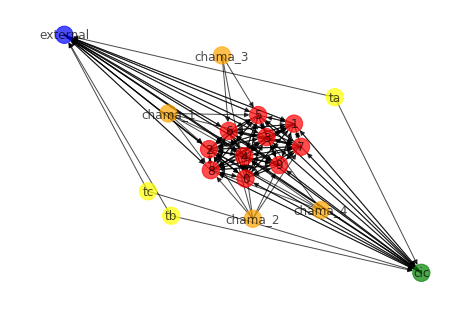

[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]


In [1]:
import math
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from model.parts.supportingFunctions import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline
from tabulate import tabulate
from typing import Dict, List

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

# The following imports NEED to be in the exact order
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from model import economyconfig
from cadCAD import configs

exec_mode = ExecutionMode()

In [2]:
exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

i = 0
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    results[i] = {}
    results[i]['result'] = result
    i += 1


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7ff660853510>, <cadCAD.configuration.Configuration object at 0x7ff6606f0150>, <cadCAD.configuration.Configuration object at 0x7ff660702c90>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7ff660853510>, <cadCAD.configuration.Configuration object at 0x7ff6606f0150>, <cadCAD.configuration.Configuration object at 0x7ff660702c90>]


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/cadCAD/utils/__init__.py:113: FutureWarning: The use of a dictionary to describe Partial State Update Blocks will be deprecated. Use a list instead.
  FutureWarning)


In [3]:
results[0]['result'].tail()

network  \
4000  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, external, cic, ...   
4001  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, external, cic, ...   
4002  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, external, cic, ...   
4003  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, external, cic, ...   
4004  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, external, cic, ...   

                                              KPIDemand  \
4000  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4001  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4002  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4003  {'0': 0, '1': 1588.48, '2': 0, '3': 0, '4': 1,...   
4004  {'0': 0, '1': 1588.48, '2': 0, '3': 0, '4': 1,...   

                                               KPISpend  \
4000  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4001  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4002  {'0': 551.11, '1': 3697.46, '2': 844.61, '3': ...   
4003  {'0': 0, '1': 1588.48, '2': 0, '3': 0, '4': 1,...   
4004  {'0': 0, '1': 1588.48, '2': 0, '3': 0, '4': 1,...   

                                     KPISpendOverDemand  VelocityOfMoney  \
4000  {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0, '4': 0,...             0.91   
4001  {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0, '4': 0,...             0.91   
4002  {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0, '4': 0,...             0.91   
4003  {'0': 0, '1': 1.0, '2': 0, '3': 0, '4': 1.0, '...             0.91   
4004  {'0': 0, '1': 1.0, '2': 0, '3': 0, '4': 1.0, '...             1.39   

                                        startingBalance  \
4000  {'0': 70128.07992565513, '1': 20374.7067738471...   
4001  {'0': 70128.07992565513, '1': 20374.7067738471...   
4002  {'0': 70128.07992565513, '1': 20374.7067738471...   
4003  {'0': 70128.07992565513, '1': 20374.7067738471...   
4004  {'0': 70128.07992565513, '1': 20374.7067738471...   

                                           30_day_spend withdraw  \
4000  {'0': 3626.04, '1': 10839.83, '2': 3478.46, '3...        0   
4001  {'0': 3626.04, '1': 10839.83, '2': 3478.46, '3...        0   
4002  {'0': 3626.04, '1': 10839.83, '2': 3478.46, '3...        0   
4003  {'0': 3626.04, '1': 10839.83, '2': 3478.46, '3...        0   
4004  {'0': 3626.04, '1': 10839.83, '2': 3478.46, '3...        0   

                                    outboundAgents  \
4000  [7, 6, 4, 6, 5, 1, 6, external, external, 7]   
4001  [7, 6, 4, 6, 5, 1, 6, external, external, 7]   
4002  [7, 6, 4, 6, 5, 1, 6, external, external, 7]   
4003  [7, 6, 4, 6, 5, 1, 6, external, external, 7]   
4004  [7, 6, 4, 6, 5, 1, 6, external, external, 7]   

                       inboundAgents  operatorFiatBalance  operatorCICBalance  \
4000  [2, 8, 7, 8, 8, 7, 0, 8, 1, 4]             62236.35         15937763.65   
4001  [2, 8, 7, 8, 8, 7, 0, 8, 1, 4]             62236.35         15937763.65   
4002  [2, 8, 7, 8, 8, 7, 0, 8, 1, 4]             62236.35         15937763.65   
4003  [2, 8, 7, 8, 8, 7, 0, 8, 1, 4]             62236.35         15937763.65   
4004  [2, 8, 7, 8, 8, 7, 0, 8, 1, 4]             62236.35         15937763.65   

                                         fundsInProcess  \
4000  {'timestep': [], 'decision': [], 'cic': [], 's...   
4001  {'timestep': [], 'decision': [], 'cic': [], 's...   
4002  {'timestep': [], 'decision': [], 'cic': [], 's...   
4003  {'timestep': [], 'decision': [], 'cic': [], 's...   
4004  {'timestep': [], 'decision': [], 'cic': [], 's...   

      totalDistributedToAgents  totalMinted  totalBurned  run  substep  \
4000                    140000            0            0    5        4   
4001                    140000            0            0    5        5   
4002                    140000            0            0    5        6   
4003                    140000            0            0    5        7   
4004                    140000            0            0    5        8   

      timestep  
4000       100  
4001       100  
4002       100  
4003       100  
4004       100

In [4]:
for i in range(0,len(results)):
    results[i]['result']['agents'] = results[i]['result'].network.apply(lambda g: np.array([get_nodes_by_type(g,'Agent')][0]))
    results[i]['result']['agent_tokens'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['tokens'] for j in get_nodes_by_type(g,'Agent')]))
    results[i]['result']['agent_native_currency'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['native_currency'] for j in get_nodes_by_type(g,'Agent')]))
    # Create dataframe variables   
    tokens = []
    for j in results[i]['result'].index:
         tokens.append(sum(results[i]['result']['agent_tokens'][j]))

    results[i]['result']['AggregatedAgentCICHolding'] = tokens  

    currency = []
    for j in results[i]['result'].index:
         currency.append(sum(results[i]['result']['agent_native_currency'][j]))

    results[i]['result']['AggregatedAgentCurrencyHolding'] = currency  

    AggregatedSpend = []
    for j in results[i]['result'].index:
         AggregatedSpend.append(sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedAgentSpend'] = AggregatedSpend   

    AggregatedDemand = []
    for j in results[i]['result'].index:
         AggregatedDemand.append(sum(results[i]['result']['KPIDemand'][j].values()))

    results[i]['result']['AggregatedAgentDemand'] = AggregatedDemand  


    AggregatedKPISpendOverDemand = []
    for j in results[i]['result'].index:
         AggregatedKPISpendOverDemand.append(sum(results[i]['result']['KPISpendOverDemand'][j].values()))

    results[i]['result']['AggregatedKPISpendOverDemand'] = AggregatedKPISpendOverDemand  


    AggregatedGapOfDemandMinusSpend = []
    for j in results[i]['result'].index:
         AggregatedGapOfDemandMinusSpend.append(sum(results[i]['result']['KPIDemand'][j].values())- sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedGapOfDemandMinusSpend'] = AggregatedGapOfDemandMinusSpend  

In [5]:
params = [30,60,90]
swept = 'Red Cross Drip Frequency'
mean_df,median_df = param_dfs(results,params,swept)
median_df.head()

timestep  VelocityOfMoney  operatorFiatBalance  operatorCICBalance  \
0         1             0.74            110000.00         16000000.00   
1         2             0.23            110000.00         16000000.00   
2         3             1.33            110000.00         16000000.00   
3         4             0.46            110000.00         16000000.00   
4         5             1.26            110000.00         16000000.00   

   totalDistributedToAgents  totalMinted  totalBurned  run  substep  \
0                         0            0            0    3        8   
1                         0            0            0    3        8   
2                         0            0            0    3        8   
3                         0            0            0    3        8   
4                         0            0            0    3        8   

   AggregatedAgentCICHolding  AggregatedAgentCurrencyHolding  \
0                  336416.12                       340426.00   
1                  336417.12                       340427.00   
2                  337196.44                       341206.32   
3                  336430.33                       340440.21   
4                  336429.83                       340439.71   

   AggregatedAgentSpend  AggregatedAgentDemand  AggregatedKPISpendOverDemand  \
0               4992.15                4992.15                          4.18   
1               1573.55                1947.48                          4.13   
2               8980.54               13666.54                          2.48   
3               3106.67                5115.06                          6.05   
4               8519.03                9272.41                          5.23   

   AggregatedGapOfDemandMinusSpend  Red Cross Drip Frequency  
0                          1035.47                        30  
1                           710.15                        30  
2                          2772.70                        30  
3                          2008.38                        30  
4                           753.38                        30

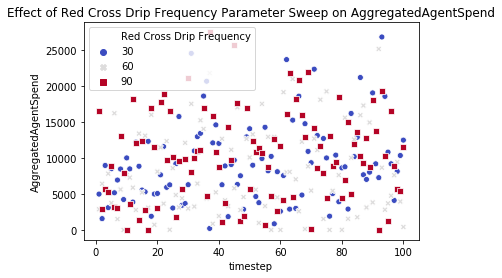

In [6]:
# plot of agent activity per timestep
param_plot(median_df,'timestep', 'AggregatedAgentSpend',swept)

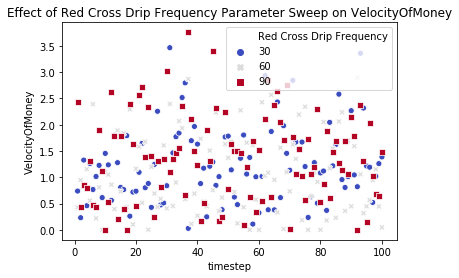

In [7]:
param_plot(median_df,'timestep', 'VelocityOfMoney',swept)

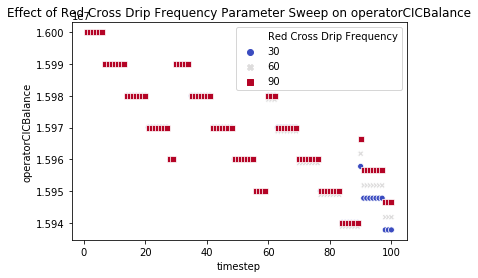

In [8]:
param_plot(median_df,'timestep', 'operatorCICBalance',swept)

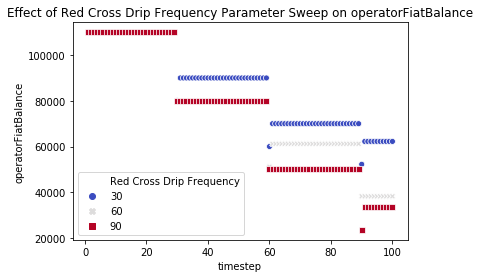

In [9]:
param_plot(median_df,'timestep', 'operatorFiatBalance',swept)

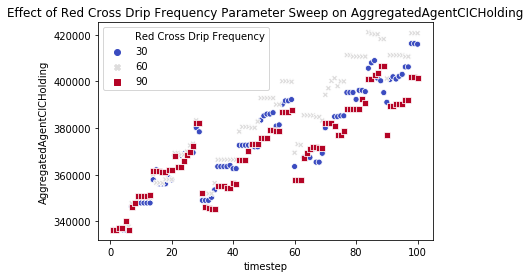

In [10]:
param_plot(median_df,'timestep', 'AggregatedAgentCICHolding',swept)

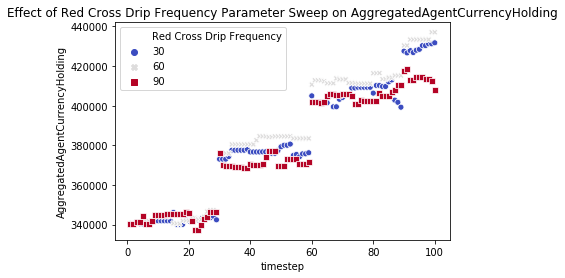

In [11]:
param_plot(median_df,'timestep', 'AggregatedAgentCurrencyHolding',swept)

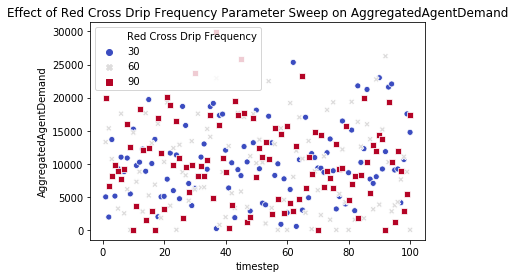

In [12]:
param_plot(median_df,'timestep', 'AggregatedAgentDemand',swept)